c:\Users\adars\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\adars\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


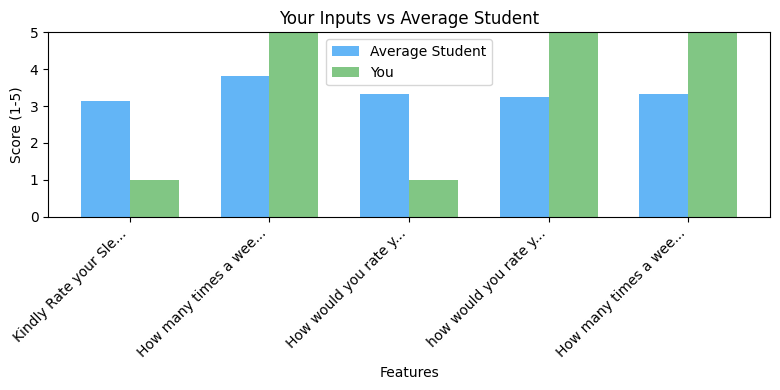

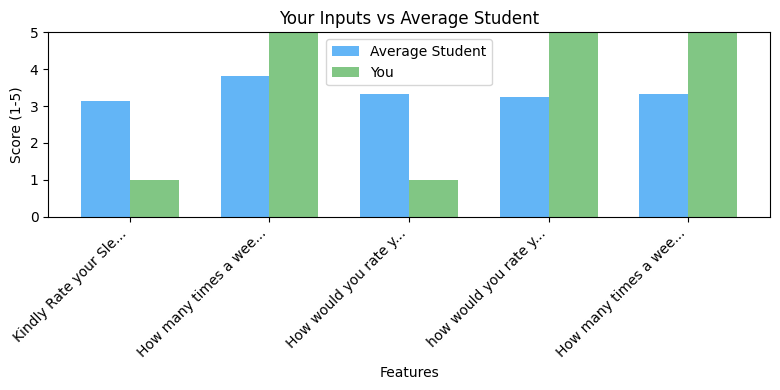

In [2]:
import tkinter as tk
from tkinter import messagebox, filedialog
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import pickle
import os

# =========================
# 1. DATA LOADING
# =========================
def load_dataset():
    file_path = filedialog.askopenfilename(
        title="Select the Student Stress CSV File",
        filetypes=[("CSV files", "*.csv")]
    )
    if not file_path:
        messagebox.showerror("File Error", "No file selected.")
        exit()
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)
    return df, file_path

data, DATA_PATH = load_dataset()

TARGET_COLUMN = [col for col in data.columns if 'stress levels' in col.lower()][0]

# Feature columns
X = data.drop(TARGET_COLUMN, axis=1)
y = data[TARGET_COLUMN]

FEATURE_NAMES = X.columns.tolist()

QUALITY_FEATURES = [
    'Kindly Rate your Sleep Quality',
    'How would you rate you academic performance ?'
]

FREQUENCY_OR_LOAD_FEATURES = [
    'How many times a week do you suffer headaches ?',
    'how would you rate your study load?',
    'How many times a week you practice extracurricular activities ?'
]

# Preprocess target
y = y.apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# 2. MODEL TRAINING / LOADING
# =========================
MODEL_FILENAME = 'student_stress_model.pkl'
if not os.path.exists(MODEL_FILENAME):
    model = make_pipeline(StandardScaler(), LogisticRegression(
        multi_class='multinomial', max_iter=1000, solver='lbfgs'))
    model.fit(X_train, y_train)
    with open(MODEL_FILENAME, 'wb') as f:
        pickle.dump(model, f)
else:
    with open(MODEL_FILENAME, 'rb') as f:
        model = pickle.load(f)

# =========================
# 3. HELPER FUNCTIONS
# =========================
def clean_label(column_name):
    cleaned = column_name.replace('?', '').replace('_', ' ').replace('  ', ' ').strip()
    if column_name in QUALITY_FEATURES:
        guide = "(1=Poor, 5=Excellent)"
    elif column_name in FREQUENCY_OR_LOAD_FEATURES:
        guide = "(1=High Stress, 5=Low Stress)"
    else:
        guide = "(1=Poor, 5=Good)"
    return f"{cleaned.capitalize()} {guide}:"

def validate_input(value):
    return value.isdigit() and 1 <= int(value) <= 5

def invert_features(user_values):
    """Invert negatively correlated features so higher always means better."""
    inverted = user_values.copy()
    for i, feature in enumerate(FEATURE_NAMES):
        if feature in FREQUENCY_OR_LOAD_FEATURES:
            inverted[i] = 6 - inverted[i]
    return inverted

def predict_stress():
    try:
        user_values = [float(entry.get()) for entry in entry_fields]
        user_values_scaled = invert_features(user_values)
        inputs_array = np.array([user_values_scaled])
        prediction = model.predict(inputs_array)[0]
        result = ["Low Stress (No Depression)", "Medium Stress (At Risk)", "High Stress (Depression)"][prediction]
        messagebox.showinfo("Prediction Result", f"The predicted stress level is:\n\n{result}")
        show_comparison_chart(user_values_scaled)
    except ValueError:
        messagebox.showerror("Input Error", "All fields must be numeric values (1-5).")
    except Exception as e:
        messagebox.showerror("Error", f"Unexpected error: {e}")

def show_comparison_chart(user_values):
    """Show user's input vs dataset average in a bar chart inside Tkinter."""
    avg_values = []
    for feature in FEATURE_NAMES:
        col = data[feature]
        if feature in FREQUENCY_OR_LOAD_FEATURES:
            avg_values.append(6 - col.mean())  # invert to match user scale
        else:
            avg_values.append(col.mean())

    fig, ax = plt.subplots(figsize=(8, 4))
    index = np.arange(len(FEATURE_NAMES))
    bar_width = 0.35

    ax.bar(index, avg_values, bar_width, label='Average Student', color='#2196F3', alpha=0.7)
    ax.bar(index + bar_width, user_values, bar_width, label='You', color='#4CAF50', alpha=0.7)

    ax.set_xlabel('Features')
    ax.set_ylabel('Score (1-5)')
    ax.set_title('Your Inputs vs Average Student')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f[:20] + "..." if len(f) > 20 else f for f in FEATURE_NAMES], rotation=45, ha='right')
    ax.set_ylim(0, 5)
    ax.legend()
    plt.tight_layout()

    # Embed in Tkinter
    canvas = FigureCanvasTkAgg(fig, master=app)
    canvas.get_tk_widget().grid(row=len(FEATURE_NAMES)+2, column=0, columnspan=2, pady=10)
    canvas.draw()

# =========================
# 4. TKINTER GUI SETUP
# =========================
app = tk.Tk()
app.title("Student Stress Predictor")
app.geometry("800x600")
app.resizable(False, False)

entry_fields = []
vcmd = (app.register(validate_input), "%P")

# Dynamic input creation
for i, col_name in enumerate(FEATURE_NAMES):
    label_text = clean_label(col_name)
    tk.Label(app, text=label_text, anchor='w', font=('Arial', 10)).grid(row=i, column=0, sticky='w', padx=10, pady=5)
    entry = tk.Entry(app, width=10, validate="key", validatecommand=vcmd, font=('Arial', 10))
    entry.grid(row=i, column=1, padx=10, pady=5)
    entry_fields.append(entry)

# Buttons
tk.Button(
    app, text="Predict Stress Level", command=predict_stress,
    bg='#4CAF50', fg='white', font=('Arial', 12, 'bold')
).grid(row=len(FEATURE_NAMES), column=0, columnspan=2, pady=15, sticky='ew', padx=10)

app.mainloop()
